# 逻辑回归从零开始实现

In [1]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃
%matplotlib inline

## 1 人工构造数据集

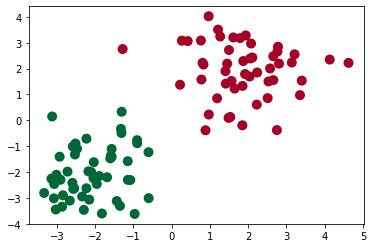

In [2]:
#人工构造数据集
#随机生成实验所需的二分类数据集x1和x2，对应标签y1,y2
#自定义数据训练集 一共100个数据
n_data = torch.ones(50, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(50, 2)
y1 = torch.zeros(50) # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(50, 2)
y2 = torch.ones(50) # 类型1 shape=(50, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
trainfeatures = torch.cat((x1, x2), 0).type(torch.FloatTensor) #trainfeatures
trainlabels = torch.cat((y1, y2), 0).type(torch.FloatTensor) #trainlabels
#可视化
plt.scatter(trainfeatures.data.numpy()[:, 0], trainfeatures.data.numpy()[:, 1], c=trainlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')

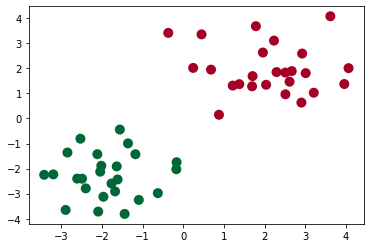

In [3]:
#自定义数据-测试集
n_data = torch.ones(25, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(25, 2)
y1 = torch.zeros(25) # 类型0 shape=(25, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(25, 2)
y2 = torch.ones(25) # 类型1 shape=(50, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
testfeatures = torch.cat((x1, x2), 0).type(torch.FloatTensor) #trainfeatures
testlabels = torch.cat((y1, y2), 0).type(torch.FloatTensor) #trainlabels
#可视化
plt.scatter(testfeatures.data.numpy()[:, 0], testfeatures.data.numpy()[:, 1], c=testlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')
#随机生成了100个数据作为训练集，前50个作为正样本标签为1，值为正，后50个为负，标签0
#随机生成50个数据集作为测试集，同上

## 2 初始化模型参数

In [4]:
#读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)
#初始化W:[2,1]和b[1]
w = torch.tensor(np.random.normal(0, 0.01, (2, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
b.requires_grad_(requires_grad=True)
w.requires_grad_(requires_grad=True)

tensor([[-0.0065],
        [-0.0137]], requires_grad=True)

## 3 定义模型

In [6]:
#逻辑回归=线性网络+sigmoid激活函数
def logits(X, w, b):
    y = torch.mm(X, w) + b
    return  1/(1+torch.pow(np.e,-y))

## 4 定义优化算法

In [7]:
#优化函数
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

#测试集准确率
def evaluate_accuracy():
    acc_sum,n = 0.0,0
    for X,y in data_iter(batch_size, testfeatures, testlabels):
        y_hat = net(X, w, b)
        y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        acc_sum += (y_hat==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

## 5 定义损失函数

In [5]:
#手动实现二元交叉熵损失函数
def logits_loss(y_hat, y):
    y = y.view(y_hat.size())
    return  -y.mul(torch.log(y_hat))-(1-y).mul(torch.log(1-y_hat))


## 6 训练模型

In [19]:
#开始训练
lr = 0.0005
num_epochs = 300
net = logits
loss = logits_loss
batch_size = 5

epochlist = np.arange(1,num_epochs+1)
losslist = []

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    
    train_l_num, train_acc_num,n = 0.0,0.0,0
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次
    
    for X, y in data_iter(batch_size, trainfeatures, trainlabels): # x和y分别是小批量样本的特征和标签
        y_hat = net(X, w, b)
        l = loss(y_hat, y).sum() # l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
        w.grad.data.zero_() # 梯度清零
        b.grad.data.zero_() # 梯度清零
        #计算每个epoch的loss
        train_l_num += l.item()
        #计算训练样本的准确率
        y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        train_acc_num += (y_hat==y).sum().item()
        #每一个epoch的所有样本数
        n+= y.shape[0]
	    #train_l = loss(net(trainfeatures, w, b), trainlabels)
        #计算测试样本的准确率
    test_acc = evaluate_accuracy()
    print('epoch %d, loss %.4f,train_acc %f,test_acc %f'%(epoch+1,train_l_num/n, train_acc_num/n, test_acc))
    losslist.append(train_l_num/n)

epoch 1, loss 0.0376,train_acc 1.000000,test_acc 1.000000
epoch 2, loss 0.0376,train_acc 1.000000,test_acc 1.000000
epoch 3, loss 0.0375,train_acc 1.000000,test_acc 1.000000
epoch 4, loss 0.0375,train_acc 1.000000,test_acc 1.000000
epoch 5, loss 0.0375,train_acc 1.000000,test_acc 1.000000
epoch 6, loss 0.0374,train_acc 1.000000,test_acc 1.000000
epoch 7, loss 0.0374,train_acc 1.000000,test_acc 1.000000
epoch 8, loss 0.0374,train_acc 1.000000,test_acc 1.000000
epoch 9, loss 0.0374,train_acc 1.000000,test_acc 1.000000
epoch 10, loss 0.0373,train_acc 1.000000,test_acc 1.000000
epoch 11, loss 0.0373,train_acc 1.000000,test_acc 1.000000
epoch 12, loss 0.0373,train_acc 1.000000,test_acc 1.000000
epoch 13, loss 0.0373,train_acc 1.000000,test_acc 1.000000
epoch 14, loss 0.0372,train_acc 1.000000,test_acc 1.000000
epoch 15, loss 0.0372,train_acc 1.000000,test_acc 1.000000
epoch 16, loss 0.0372,train_acc 1.000000,test_acc 1.000000
epoch 17, loss 0.0371,train_acc 1.000000,test_acc 1.000000
epoch 

epoch 143, loss 0.0341,train_acc 1.000000,test_acc 1.000000
epoch 144, loss 0.0341,train_acc 1.000000,test_acc 1.000000
epoch 145, loss 0.0341,train_acc 1.000000,test_acc 1.000000
epoch 146, loss 0.0340,train_acc 1.000000,test_acc 1.000000
epoch 147, loss 0.0340,train_acc 1.000000,test_acc 1.000000
epoch 148, loss 0.0340,train_acc 1.000000,test_acc 1.000000
epoch 149, loss 0.0340,train_acc 1.000000,test_acc 1.000000
epoch 150, loss 0.0340,train_acc 1.000000,test_acc 1.000000
epoch 151, loss 0.0339,train_acc 1.000000,test_acc 1.000000
epoch 152, loss 0.0339,train_acc 1.000000,test_acc 1.000000
epoch 153, loss 0.0339,train_acc 1.000000,test_acc 1.000000
epoch 154, loss 0.0339,train_acc 1.000000,test_acc 1.000000
epoch 155, loss 0.0338,train_acc 1.000000,test_acc 1.000000
epoch 156, loss 0.0338,train_acc 1.000000,test_acc 1.000000
epoch 157, loss 0.0338,train_acc 1.000000,test_acc 1.000000
epoch 158, loss 0.0338,train_acc 1.000000,test_acc 1.000000
epoch 159, loss 0.0338,train_acc 1.00000

epoch 286, loss 0.0313,train_acc 1.000000,test_acc 1.000000
epoch 287, loss 0.0313,train_acc 1.000000,test_acc 1.000000
epoch 288, loss 0.0313,train_acc 1.000000,test_acc 1.000000
epoch 289, loss 0.0313,train_acc 1.000000,test_acc 1.000000
epoch 290, loss 0.0313,train_acc 1.000000,test_acc 1.000000
epoch 291, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 292, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 293, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 294, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 295, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 296, loss 0.0312,train_acc 1.000000,test_acc 1.000000
epoch 297, loss 0.0311,train_acc 1.000000,test_acc 1.000000
epoch 298, loss 0.0311,train_acc 1.000000,test_acc 1.000000
epoch 299, loss 0.0311,train_acc 1.000000,test_acc 1.000000
epoch 300, loss 0.0311,train_acc 1.000000,test_acc 1.000000


## 7 结果可视化

In [ ]:
import matplotlib as plt

In [20]:
epochlist

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [21]:
losslist

[0.03758352125063538,
 0.03755560097284615,
 0.037527965158224104,
 0.037500280700623986,
 0.03747266449034214,
 0.03744532184675336,
 0.037417694870382545,
 0.03739032603800297,
 0.03736314117908478,
 0.037335669957101345,
 0.0373084132373333,
 0.037281189914792776,
 0.037253979369997976,
 0.037226968295872215,
 0.0371998205780983,
 0.03717292871326208,
 0.037145876586437226,
 0.037118922527879475,
 0.03709238689392805,
 0.03706532580778003,
 0.03703841660171747,
 0.0370117649808526,
 0.03698516089469194,
 0.03695854155346751,
 0.0369318949431181,
 0.03690550597384572,
 0.03687908854335546,
 0.03685254028066993,
 0.03682610314339399,
 0.036799832805991174,
 0.036773529984056946,
 0.03674733500927687,
 0.03672114525921643,
 0.036694972440600396,
 0.03666888661682606,
 0.036642883233726026,
 0.03661693468689919,
 0.036590975411236286,
 0.036565091973170635,
 0.03653924632817507,
 0.036513374112546446,
 0.03648747693747282,
 0.036461996883153915,
 0.03643624238669872,
 0.0364105552993714

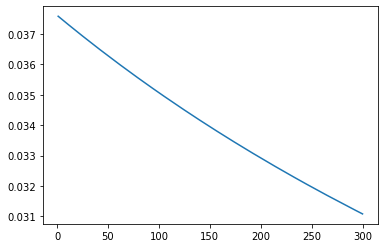

In [22]:
plt.plot(epochlist,losslist)